In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import pandas as pd
from cuml.manifold.umap import UMAP as cumlUMAP
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### load data

In [3]:
DATASET_ID = 'BIRD_DB_Vireo_cassinii'
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'cassins.pickle'

In [4]:
syllable_df = pd.read_pickle(df_loc)
del syllable_df['audio']

In [5]:
syllable_df[:3]

,start_time,end_time,labels,indv,indvi,subject_importance,key,rate,spectrogram
0,9.842790,10.105938,ah,ORA,0,Primary subject,2014-05-29_10-10-00-000000,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3059005, 0.4..."
1,72.031245,72.346332,ah,ORA,0,Primary subject,2014-05-29_10-10-00-000000,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.12574787, 0.12236..."
2,74.130176,74.376012,bz,ORA,0,Primary subject,2014-05-29_10-10-00-000000,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2822944, 0.0..."


In [6]:
len(syllable_df)

67032

In [7]:
top_indv_df = pd.DataFrame(
    {indv: [np.sum(syllable_df.indv == indv)] for indv in syllable_df.indv.unique()}
).T.sort_values(by=[0], ascending=False)
top_indv_df[:15]

,0
AGBk,9875
AOBu,7704
WABk,7373
BuRA,5527
AGO,4595
RYA,3582
YAW,3422
GRA,3045
ORA,2805
YBuA,2638


In [8]:
top_indvs = top_indv_df[:15].index
top_indvs

Index(['AGBk', 'AOBu', 'WABk', 'BuRA', 'AGO', 'RYA', 'YAW', 'GRA', 'ORA',
       'YBuA', 'Unbanded East', 'AYO', 'Meadow', 'Gate CAVI', 'GAY'],
      dtype='object')

In [9]:
np.shape(syllable_df.spectrogram.values[0])

(32, 31)

### project

(9875, 992)


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


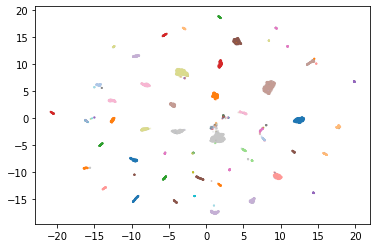

(7704, 992)


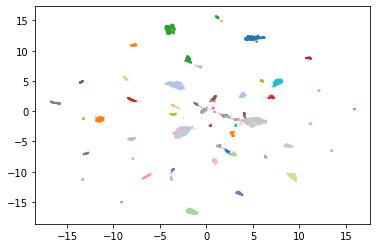

(7373, 992)


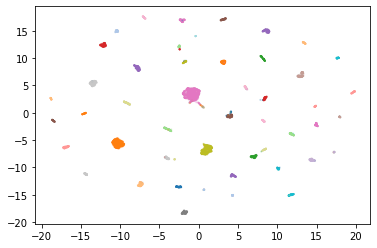

(5527, 992)


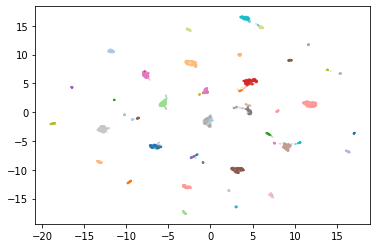

(4595, 992)


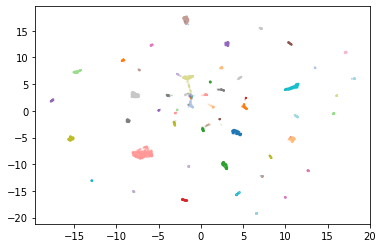

(3582, 992)


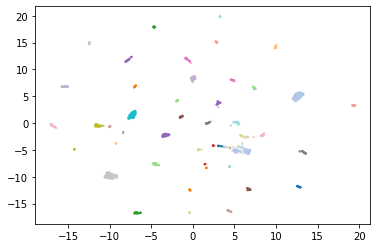

(3422, 992)


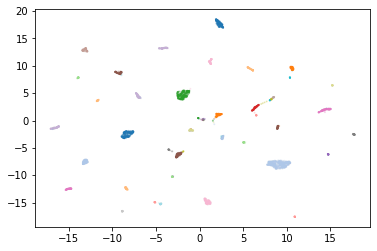

(3045, 992)


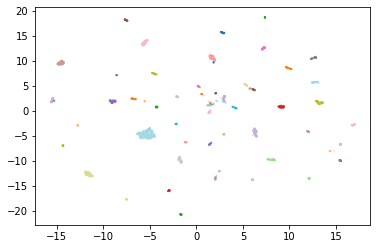

(2805, 992)


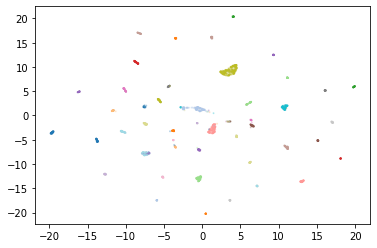

(2638, 992)


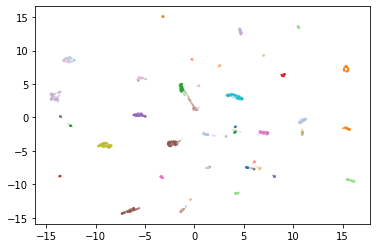

(2324, 992)


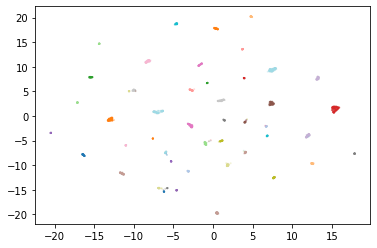

(1543, 992)


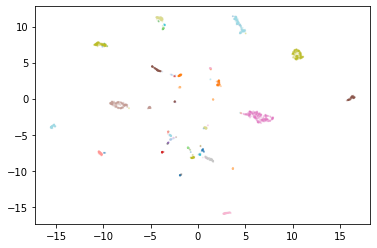

(1515, 992)


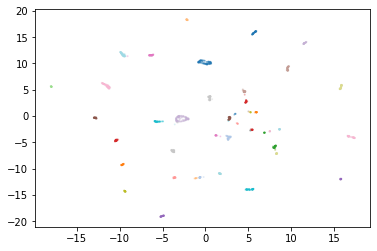

(1136, 992)


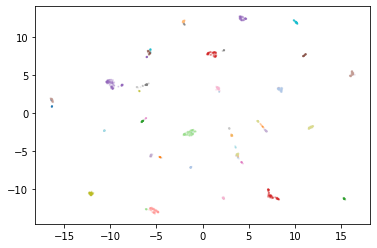

(1068, 992)


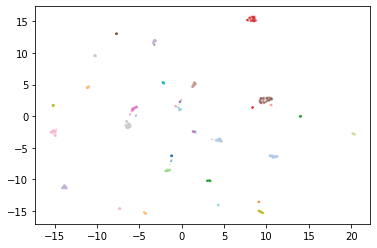

In [10]:
for indv in tqdm(top_indvs):
    subset_df = syllable_df[syllable_df.indv == indv]
    
    specs = list(subset_df.spectrogram.values)
    specs = [i/np.max(i) for i in tqdm(specs, leave=False)]
    specs_flattened = flatten_spectrograms(specs)
    print(np.shape(specs_flattened))
    
    cuml_umap = cumlUMAP()
    embedding = cuml_umap.fit_transform(specs_flattened)
    subset_df['umap'] = list(embedding)
    
    unique_labs = np.unique(subset_df.labels.values)
    unique_labs_dict = {lab:i for i, lab in enumerate(unique_labs)}
    lab_list = [unique_labs_dict[i] for i in subset_df.labels.values]
    fig, ax = plt.subplots()
    ax.scatter(embedding[:,0], embedding[:,1], s=1, c=lab_list, cmap=plt.cm.tab20, alpha = 0.25)
    #ax.set_xlim([-8,8])
    #ax.set_ylim([-8,8])
    plt.show()
    
    ensure_dir(DATA_DIR / 'embeddings' / DATASET_ID / 'indvs')
    subset_df.to_pickle(DATA_DIR / 'embeddings' / DATASET_ID / 'indvs' / (indv + '.pickle'))